# Gym Dataset

The dataset cointains the energy consumpion in KW of a gym.  
The consumption has been registered every hour on a period of time over 6 months.

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

import pandas_profiling
from datetime import datetime

In [183]:
data = pd.read_csv("rec-center-hourly_out_original.csv", sep=",", parse_dates=['timestamp'])
data.set_index('timestamp', inplace=True)
data.shape

(4391, 4)

In [167]:
data.head()

,kw_energy_consumption,prediction,anomaly_score,anomaly_likelihood
timestamp,,,,
2010-07-02 00:00:00,21.2,21.2,1.0,0.5
2010-07-02 01:00:00,16.4,16.4,1.0,0.5
2010-07-02 02:00:00,4.7,4.7,1.0,0.5
2010-07-02 03:00:00,4.7,4.7,1.0,0.5
2010-07-02 04:00:00,4.6,4.6,1.0,0.5


In [168]:
data.tail()

,kw_energy_consumption,prediction,anomaly_score,anomaly_likelihood
timestamp,,,,
2010-12-31 18:00:00,21.1,19.162911,0.000,0.860247
2010-12-31 19:00:00,10.5,5.506965,0.150,0.714829
2010-12-31 20:00:00,5.3,5.506965,0.125,0.555399
2010-12-31 21:00:00,5.1,39.353417,0.100,0.580539
2010-12-31 22:00:00,5.0,7.824440,0.050,0.646008


In [169]:
data.describe()

,kw_energy_consumption,prediction,anomaly_score,anomaly_likelihood
count,4391.000000,4391.000000,4391.000000,4391.000000
mean,31.304783,31.929570,0.046914,0.724870
std,19.638002,19.942975,0.122510,0.145901
min,4.400000,4.500000,0.000000,0.500000
25%,9.300000,8.400751,0.000000,0.599889
50%,37.700000,38.290916,0.025000,0.739968
75%,46.400000,46.285018,0.050000,0.831829
max,90.900000,72.688629,1.000000,1.000000


## Exploring our Time Series

In [86]:
ts = pd.Series(data.kw_energy_consumption)

In [87]:
pandas_profiling.ProfileReport(data)

Number of variables,5
Number of observations,4391
Total Missing (%),0.0%
Total size in memory,171.6 KiB
Average record size in memory,40.0 B
Numeric,4
Categorical,0
Boolean,0
Date,0
Text (Unique),1
Rejected,0


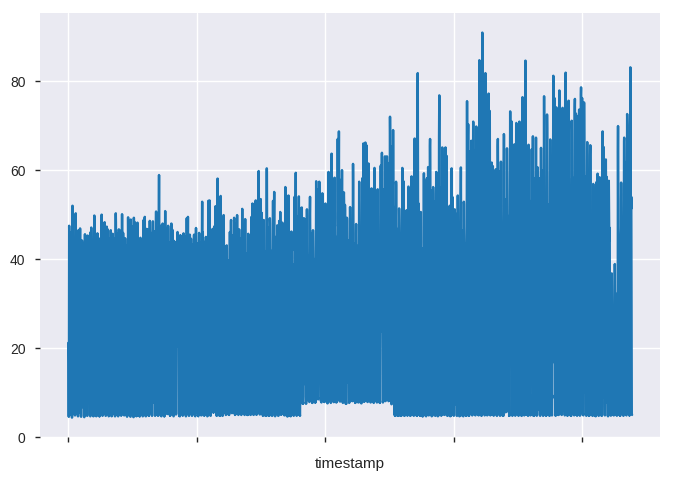

In [172]:
ts.plot()
# fig, ax = plt.subplots() #figsize=(15,7)
# ts.plot(ax=ax)

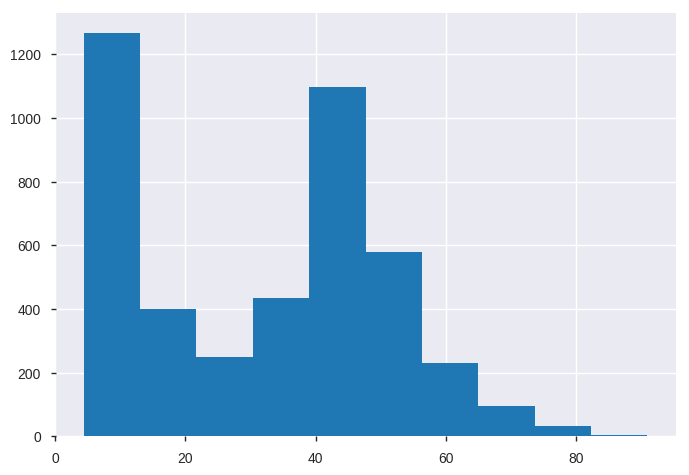

In [89]:
ts.hist()

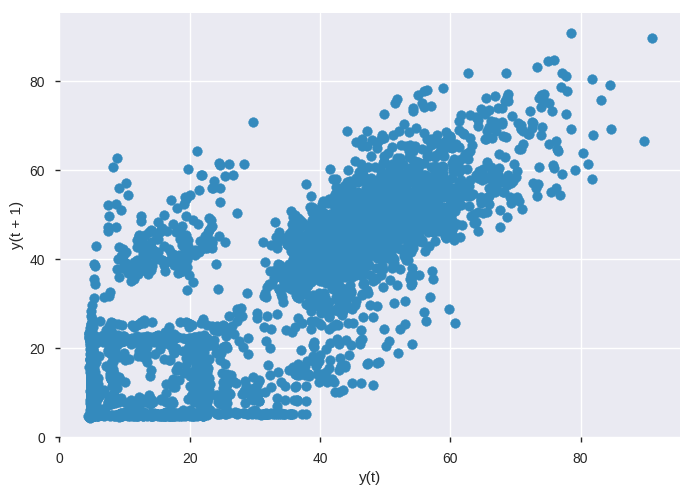

In [90]:
from pandas.plotting import lag_plot
lag_plot(ts)

**Correlation between observations and their lag1 values**: We can appreciate NOISE in the the data and that observations are positively correlated.

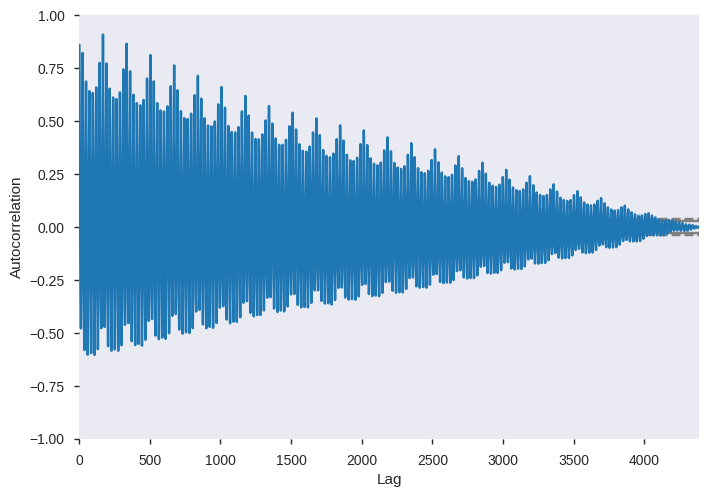

In [70]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ts)

**Autocorrelation**: really high (as expected). We see cycles of strong negative and positive correlation. This captures the relationship of an observation with past observations in the same and opposite seasons or times of year. Sine waves like those seen in this example are a strong sign of seasonality in the dataset.

# Adding the Anomaly Score & LH

## Definitions

**Anomaly Score (AS)**:
            - 0 if current value was predicted
            - 1 if value was totally unpredicted
            - bw. 0 and 1 if similar\* to predicted value 
\* *similar after encoding; similarity in the column space*


**Anomaly LH**:
            - estimate the probability distribution of historical AS
            - compute LH that the recent AS comes from same distribution as historical AS

---
**Some Considerations:**
- For this experiment the window for the LH has been set to 400. Ergo for the first 400 observation the LH is 0.
We set LH to 400 so that the algorithm can learn from the first 400 obs. and the AS level down.
- We are thresholding Anomaly_LH rather thern AS. Why? AS would give too many **FP**, since data are noisy.    

In [164]:
# a = 380
# b = 450
# ticks = np.arange(a, b, 50)

# fig, axes = fig.subplots(3)

# plt.figure(1)
# plt.subplot(311)
# plt.plot(data.kw_energy_consumption[a:b])
# plt.title('Hotgym Anomaly Detection')
# plt.ylabel('kw_consumption')
# #plt.xticks(ticks, data.loc[ticks, ''].values)

# plt.subplot(312)
# plt.plot(data.anomaly_score.values[a:b])
# plt.ylabel('anomaly_score')
# #plt.xticks(ticks, data.loc[ticks, 'timestamp'].values)

# plt.subplot(313)
# plt.plot(data.anomaly_likelihood[a:b])
# plt.ylabel('anomaly_LH')
# plt.xlabel('time(h)')
# #plt.xticks(ticks, data.loc[ticks, 'timestamp'].values)

# plt.show()

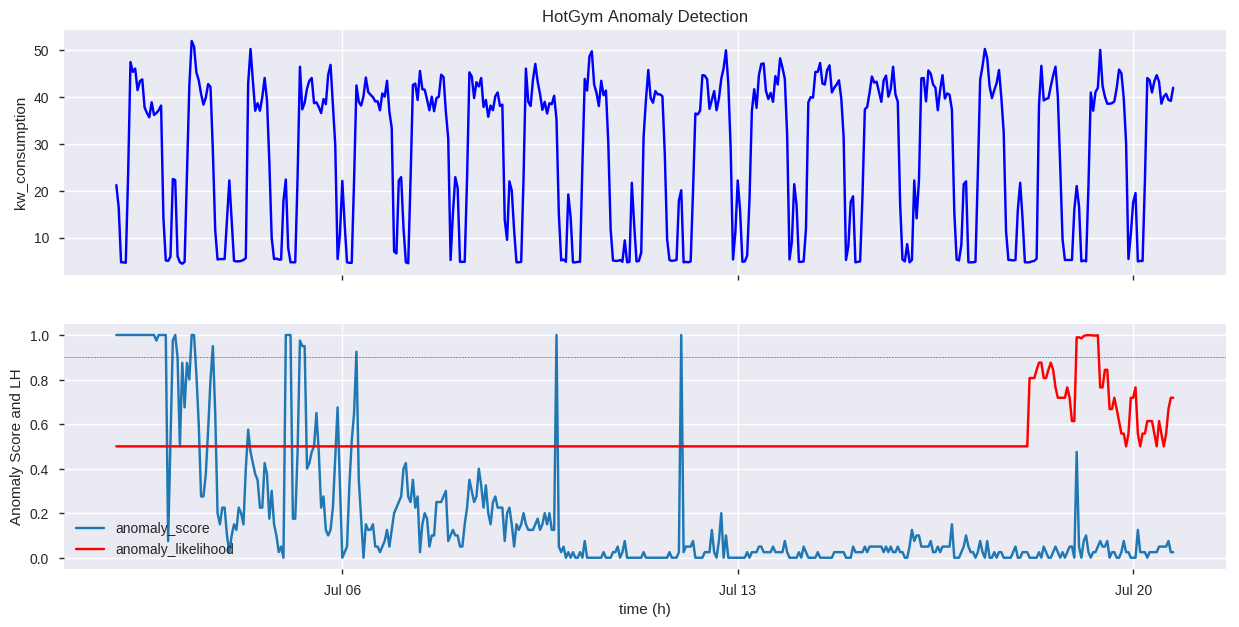

In [187]:
a = 0
b = 450

fig, ax = plt.subplots(2, sharex=True, figsize=(15,7))
ax[0].plot(data.kw_energy_consumption[a:b], color='b')
ax[0].set(ylabel='kw_consumption', title='HotGym Anomaly Detection')
ax[1].plot(data.anomaly_score[a:b])
ax[1].set(ylabel='Anomaly Score and LH')
ax[1].plot(data.anomaly_likelihood[a:b], color='r')
ax[1].axhline(y=0.9, 
              color='r', linestyle='--', linewidth=0.4)
              #xmin=data.anomaly_likelihood.index[a], xmax=data.anomaly_likelihood.index[b])
ax[1].set(xlabel='time (h)')
ax[1].legend(loc=3)

#set ticks every week
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

Moving further in our time series, we can see that AS stabilizes belove `0.2`.  
Setting the **threshold** of the LH to 0.9 seems to be 'ok'.

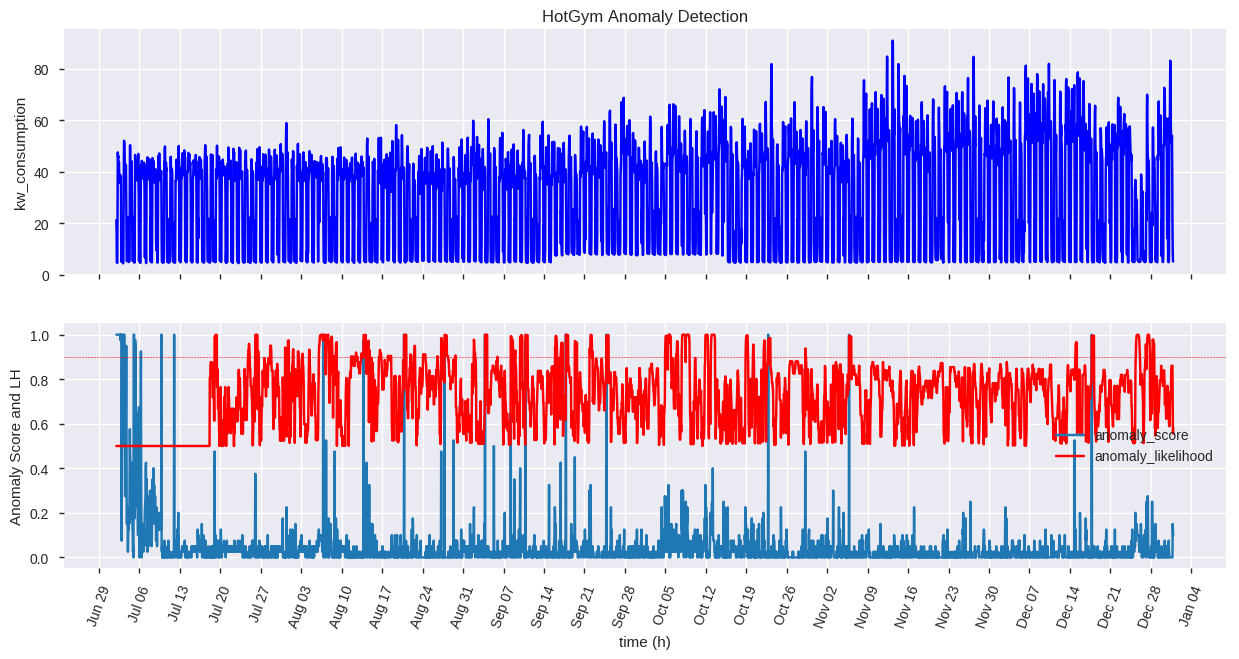

In [196]:
a = 0
b = -1

fig, ax = plt.subplots(2, sharex=True, figsize=(15,7))
ax[0].plot(data.kw_energy_consumption[a:b], color='b')
ax[0].set(ylabel='kw_consumption', title='HotGym Anomaly Detection')
ax[1].plot(data.anomaly_score[a:b])
ax[1].set(ylabel='Anomaly Score and LH')
ax[1].plot(data.anomaly_likelihood[a:b], color='r')
ax[1].axhline(y=0.9, 
              color='r', linestyle='--', linewidth=0.4)
              #xmin=data.anomaly_likelihood.index[a], xmax=data.anomaly_likelihood.index[b])
ax[1].set(xlabel='time (h)')
ax[1].legend(loc=5)

#set ticks every week
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[1].tick_params(axis='x', rotation=70)


## Load Anomaly Data

We set the `kw_energy_consumption = 0` for every `Tuesday` in October.

In [202]:
data_an = pd.read_csv("rec-center-hourly_out_notues.csv", sep=",", parse_dates=['timestamp'])
data_an.set_index('timestamp', inplace=True)
ts_oct_an = data_an.loc['2010-10-01':'2010-12-01']
ts_oct = data.loc['2010-10-01':'2010-12-01']

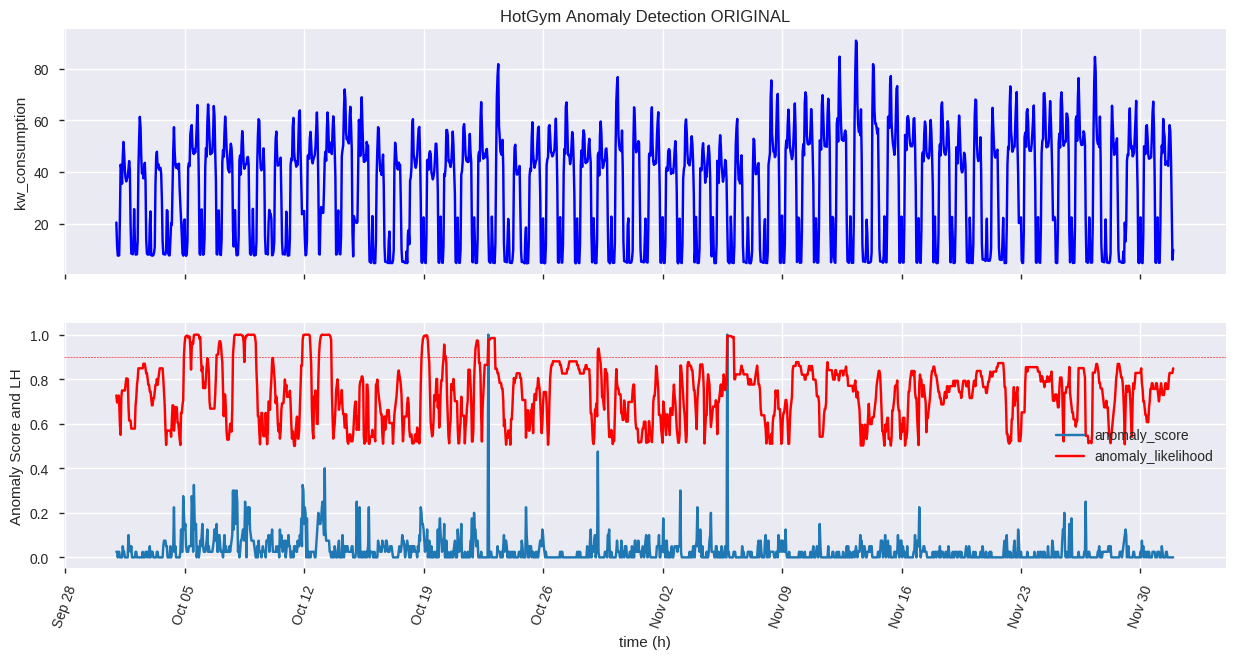

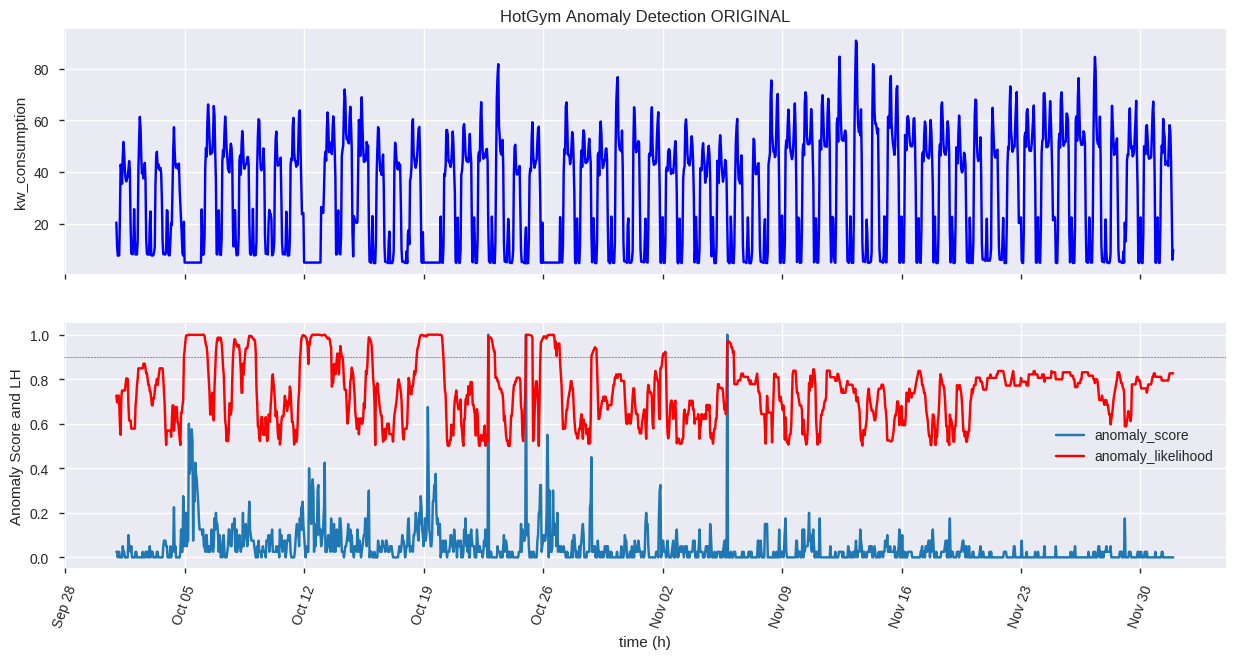

In [205]:
a = 0
b = -1

fig, ax = plt.subplots(2, sharex=True, figsize=(15,7))
ax[0].plot(ts_oct.kw_energy_consumption[a:b], color='b')
ax[0].set(ylabel='kw_consumption', title='HotGym Anomaly Detection ORIGINAL')
ax[1].plot(ts_oct.anomaly_score[a:b])
ax[1].set(ylabel='Anomaly Score and LH')
ax[1].plot(ts_oct.anomaly_likelihood[a:b], color='r')
ax[1].axhline(y=0.9, 
              color='r', linestyle='--', linewidth=0.4)
              #xmin=data.anomaly_likelihood.index[a], xmax=data.anomaly_likelihood.index[b])
ax[1].set(xlabel='time (h)')
ax[1].legend(loc=5)

#set ticks every week
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[1].tick_params(axis='x', rotation=70)


# octber tuesdays off

a = 0
b = -1

fig, ax = plt.subplots(2, sharex=True, figsize=(15,7))
ax[0].plot(ts_oct_an.kw_energy_consumption[a:b], color='b')
ax[0].set(ylabel='kw_consumption', title='HotGym Anomaly Detection ORIGINAL')
ax[1].plot(ts_oct_an.anomaly_score[a:b])
ax[1].set(ylabel='Anomaly Score and LH')
ax[1].plot(ts_oct_an.anomaly_likelihood[a:b], color='r')
ax[1].axhline(y=0.9, 
              color='r', linestyle='--', linewidth=0.4)
              #xmin=data.anomaly_likelihood.index[a], xmax=data.anomaly_likelihood.index[b])
ax[1].set(xlabel='time (h)')
ax[1].legend(loc=5)

#set ticks every week
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[1].tick_params(axis='x', rotation=70)

All the `Tuesdays` are flaged as an Anomaly. But as October passes by, the anomalies are constrained to the `Tuesday` solely and not to the other days.  
The first Tuesday in November (`Nov 02`) the algorithm is also expecting a *dead tuesday*, but since it is not the case it flags it as an anomaly.  

Anyway *October* seems to be a strange month if we observe the number of anomalies we run into (see original series).  
A positive note, is that the algorithm flagged correctly the anomaly we built in.